## Встановлення пакетів

In [1]:
# %pip install numpy==1.26.4 tensorflow matplotlib
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

## Імпорт пакетів

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, ConcatDataset
from collections import Counter
import matplotlib.pyplot as plt
torch.backends.cudnn.benchmark = True
import os
import random
from collections import defaultdict

## Підготовка датасету

In [11]:
path = 'Formula One Cars'

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmentation_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=[-30, 30])
    ], p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.ImageFolder(root=path, transform=transform)

train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])

train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

augmented_full_dataset = datasets.ImageFolder(root=path, transform=augmentation_transform)
train_dataset = ConcatDataset([train_dataset, augmented_full_dataset])

train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 2882
Val samples: 134
Test samples: 336


## Візуалізація зображень з датасету

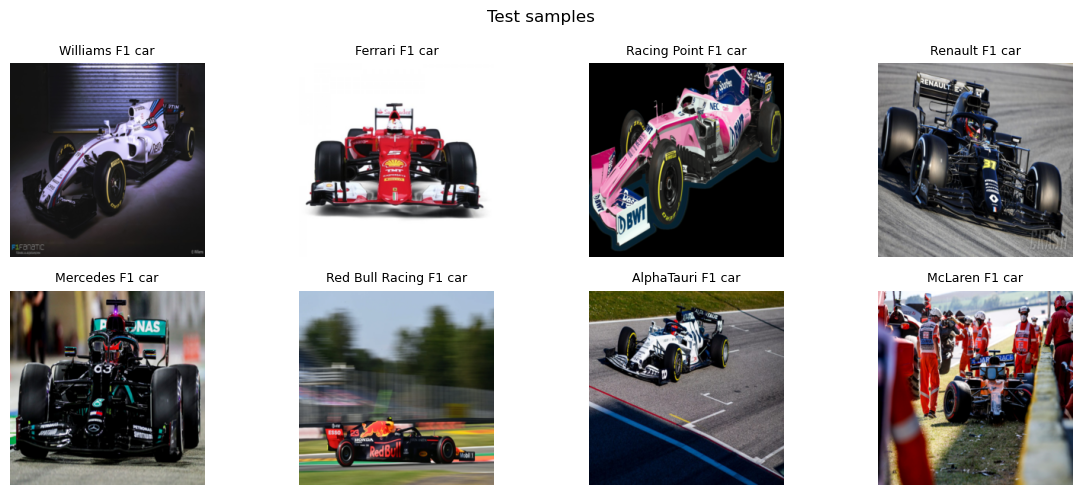

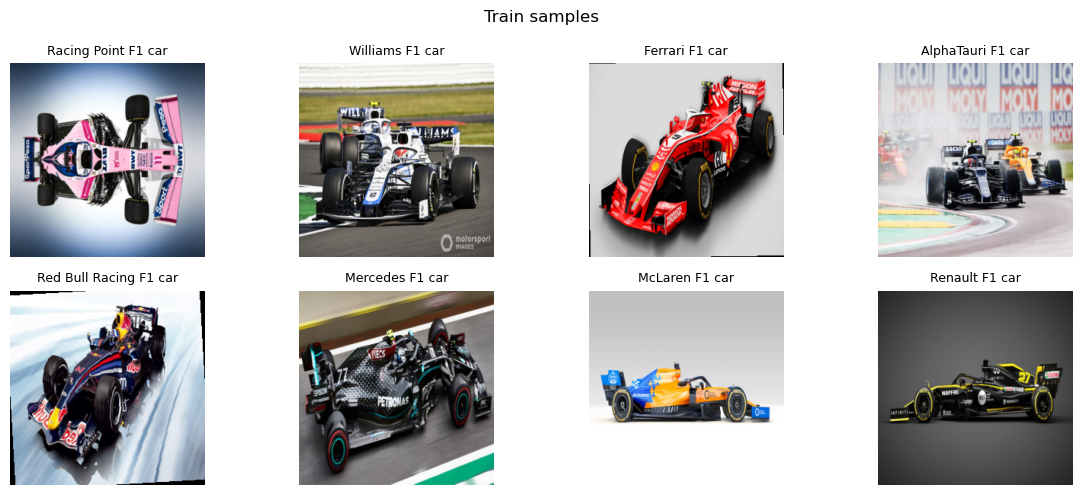

In [23]:
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor

def plot_image(img, title, index, total_rows, total_cols):
    plt.subplot(total_rows, total_cols, index)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title, fontsize=9)
    plt.axis('off')
    
def collect_class_samples(loader, class_names, samples_per_class):
    seen = {cls: 0 for cls in class_names}
    collected = []
    for images, labels in loader:
        for img, label in zip(images, labels):
            class_idx = label.item()
            class_name = class_names[class_idx]
            if seen[class_name] < samples_per_class:
                collected.append((img, class_name))
                seen[class_name] += 1
            if all(count >= samples_per_class for count in seen.values()):
                return collected
    return collected

def show_samples_from_loader(loader, class_names, samples_per_class=2, title = None):
    samples = collect_class_samples(loader, class_names, samples_per_class)
    rows = 2
    cols = (len(samples) + 1) // 2

    plt.figure(figsize=(cols * 3, rows * 2.5))
    
    if title:
        plt.suptitle(title)
    
    for i, (img, title) in enumerate(samples, 1):
        img = denormalize(img).numpy()
        plot_image(img, title, i, rows, cols)
    plt.tight_layout()
    
    plt.show()
    

show_samples_from_loader(test_loader, full_dataset.classes, 1, "Test samples")
show_samples_from_loader(train_loader, full_dataset.classes, 1, "Train samples")

## Кількість зображень на клас

Було проведено ручне очищення датасету: видалено нерелевантні зображення (наприклад фото мерча команд, або ж боліди до сезону 2013) та зображення, які були не відповідали своїм класам.
У результаті датасет зменшився більш ніж на чверть

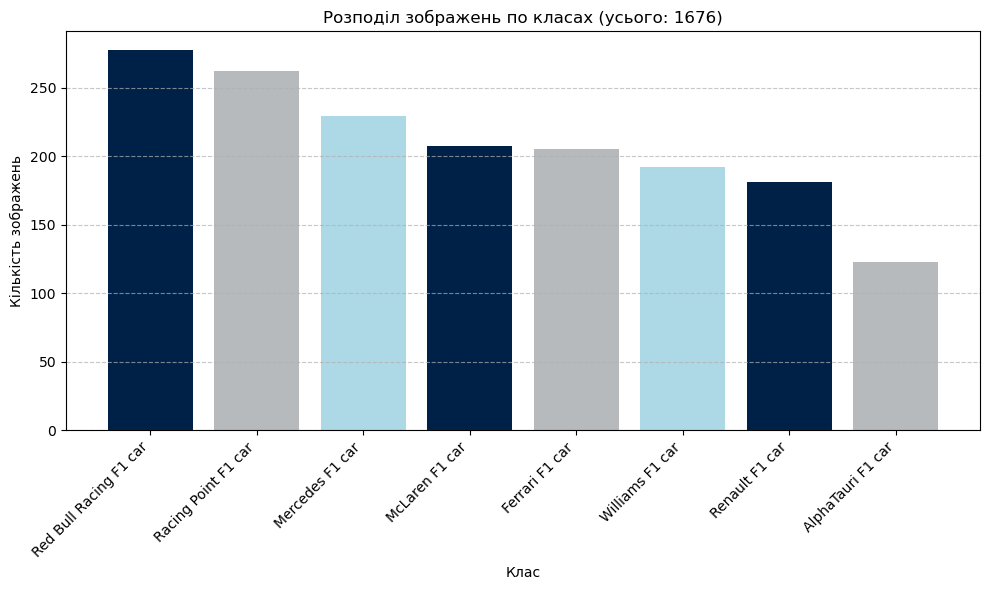

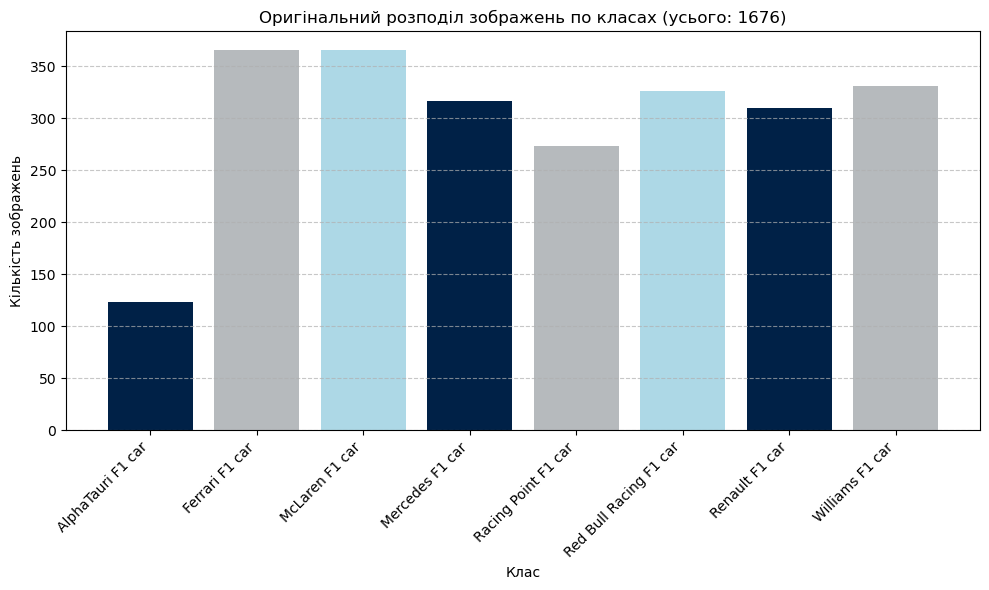

In [13]:
label_indices = full_dataset.targets
label_counts = Counter(label_indices)
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
class_names = [idx_to_class[idx] for idx, _ in sorted_items]
image_counts = [count for _, count in sorted_items]
total_images = sum(image_counts)

colors = [
    "#002147",
    "#B6BABD",
    "#ADD8E6"
]

plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color=colors)
plt.xlabel("Клас")
plt.ylabel("Кількість зображень")
plt.title(f"Розподіл зображень по класах (усього: {total_images})")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# оригінальний датасет
old_dataset_path = "Formula One Cars - original"
original_dataset = datasets.ImageFolder(old_dataset_path)

original_label_indices = original_dataset.targets
original_label_counts = Counter(original_label_indices)
class_names = [k for k, _ in original_dataset.class_to_idx.items()]
original_image_counts = [original_label_counts[original_dataset.class_to_idx[class_name]] for class_name in class_names]
original_total_images = sum(image_counts)

plt.figure(figsize=(10, 6))
plt.bar(class_names, original_image_counts, color=colors)
plt.xlabel("Клас")
plt.ylabel("Кількість зображень")
plt.title(f"Оригінальний розподіл зображень по класах (усього: {original_total_images})")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Клас згорткової нейронної мережі

In [6]:
class CnnF1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 128, 256)
        self.fc2 = nn.Linear(256, 8)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, save_path="cnn_f1.pt"):
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        train_loss_history.append(train_loss / len(train_loader))
        train_acc_history.append(train_acc)

        model.eval()
        val_loss, val_correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_acc)
        print(f"\nЕпоха: {epoch+1}/{epochs}")
        
    torch.save(model.state_dict(), save_path)
    print(f"\nМодель збережено: {save_path}")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Тренувальна точність")
    plt.plot(val_acc, label="Валідаційна точність")
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Тренувальні втрати")
    plt.plot(val_loss, label="Валідаційні втрати")
    plt.title("Loss")
    plt.legend()


## Тренування моделі


Епоха: 1/50

Епоха: 2/50

Епоха: 3/50

Епоха: 4/50

Епоха: 5/50

Епоха: 6/50

Епоха: 7/50

Епоха: 8/50

Епоха: 9/50

Епоха: 10/50

Епоха: 11/50

Епоха: 12/50

Епоха: 13/50

Епоха: 14/50

Епоха: 15/50

Епоха: 16/50

Епоха: 17/50

Епоха: 18/50

Епоха: 19/50

Епоха: 20/50

Епоха: 21/50

Епоха: 22/50

Епоха: 23/50

Епоха: 24/50

Епоха: 25/50

Епоха: 26/50

Епоха: 27/50

Епоха: 28/50

Епоха: 29/50

Епоха: 30/50

Епоха: 31/50

Епоха: 32/50

Епоха: 33/50

Епоха: 34/50

Епоха: 35/50

Епоха: 36/50

Епоха: 37/50

Епоха: 38/50

Епоха: 39/50

Епоха: 40/50

Епоха: 41/50

Епоха: 42/50

Епоха: 43/50

Епоха: 44/50

Епоха: 45/50

Епоха: 46/50

Епоха: 47/50

Епоха: 48/50

Епоха: 49/50

Епоха: 50/50

Модель збережено: cnn_f1.pt


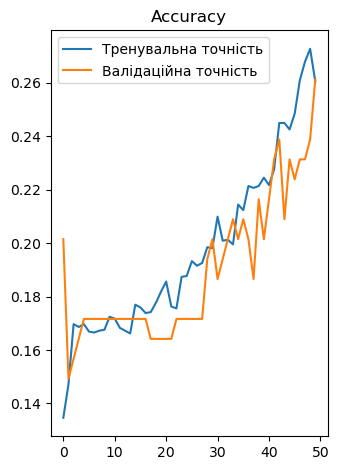

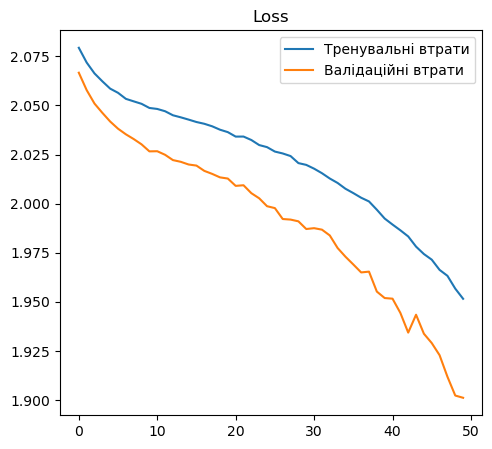

In [15]:
device = torch.device('cuda')

model = CnnF1().to(device)

epochs = 50
batch_size = 128
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs
)

plot_metrics(train_loss, val_loss, train_acc, val_acc)

## Обрахування метрик

Порівняння модел

In [21]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_model(model_path, model_class, val_loader, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return acc, f1

model_dir = "pre-trained-models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pt")]

results = []

for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    acc, f1 = evaluate_model(model_path, CnnF1, val_loader, device)
    results.append((model_file, acc, f1))
    print("\n" + model_file)
    print(f"Точність: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")



cnn_f1_10epochs.pt
Точність: 0.1791
F1 Score: 0.0567

cnn_f1_25epochs.pt
Точність: 0.1716
F1 Score: 0.0499

cnn_f1_50epochs.pt
Точність: 0.2612
F1 Score: 0.1751


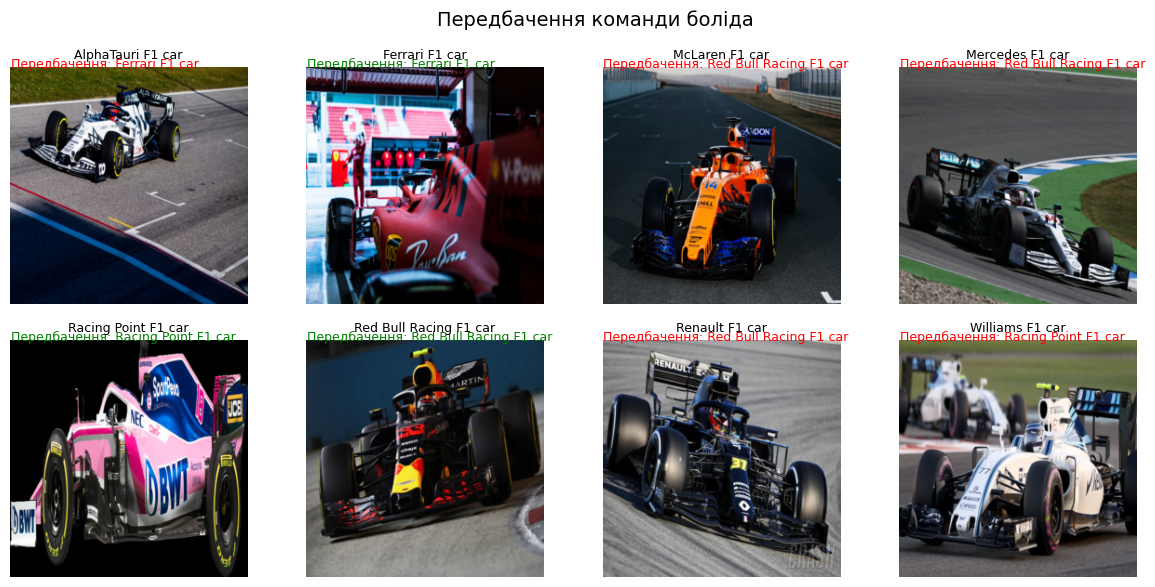

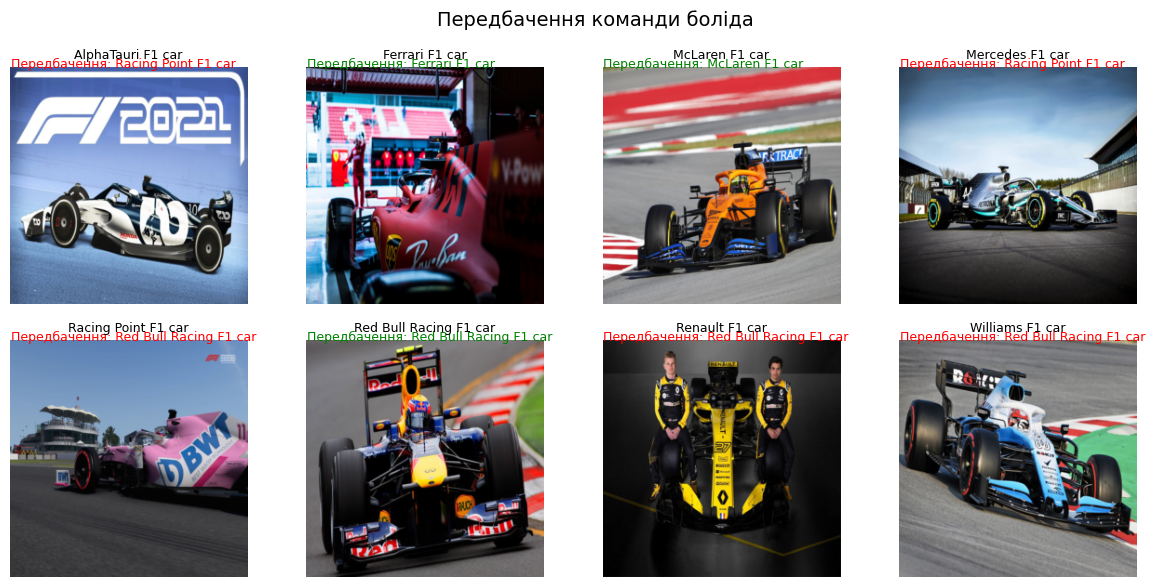

In [39]:
def plot_prediction(img, truth, prediction, index, total_rows, total_cols):
    color = "green" if truth == prediction else "red"
    
    plt.subplot(total_rows, total_cols, index)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(truth, fontsize=9)
    plt.axis('off')
    plt.text(0.5, -0.3, f"Передбачення: {prediction}", fontsize=9, color=color)

def collect_one_sample_per_class(loader, class_names, device):
    class_to_images = defaultdict(list)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        for img, label in zip(images, labels):
            class_idx = label.item()
            class_name = class_names[class_idx]
            class_to_images[class_name].append((img, label))
        
        if all(len(class_to_images[cls]) > 0 for cls in class_names):
            break

    selected_samples = []
    for class_name in class_names:
        samples = class_to_images[class_name]
        if samples:
            selected_samples.append(random.choice(samples))

    return selected_samples

def show_predictions(model, loader, class_names, device, title=None):
    model.eval()
    samples = collect_one_sample_per_class(loader, class_names, device)
    rows = 2
    cols = (len(samples) + 1) // 2

    plt.figure(figsize=(cols * 3, rows * 3))

    if title:
        plt.suptitle(title, fontsize=14)

    with torch.no_grad():
        for i, (img, label) in enumerate(samples, 1):
            input_img = img.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            truth_class = class_names[label.item()]
            predicted_class = class_names[pred.item()]
            
            img_np = denormalize(img.cpu()).numpy()
            plot_prediction(img_np, truth_class, predicted_class, i, rows, cols)

    plt.tight_layout()
    plt.show()


model.load_state_dict(torch.load("pre-trained-models/cnn_f1_50epochs.pt"))
model.to(device)

show_predictions(model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")
show_predictions(model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")
